# CS 273A Final Project: Insulin Usage Level Prediction

In [ ]:
#Mount to your google drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/', force_remount= True)

Mounted at /content/drive/


## Part 1: Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/dataset_diabetes/diabetic_data.csv")

In [ ]:
# Disbribe the overall data distribution
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [ ]:
# Get all features of the data and show the number of feature columns we have
all_columns = []
for col in data.columns:
    all_columns.append(col)

print("All features:", all_columns)
print("-"*20)
print("The number features we have:", len(all_columns))

All features: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
--------------------
The number features we have: 50


As we can see, we have in total 50 feature columns if we do not consider the target feature. For each feature, we have 101766 rows of data.

In [ ]:
# Seperate data by type: 1. categorical, 2. numerical.
cate_data = []
numerical_data = []
for i in all_columns:
    if all(isinstance(x, float) or isinstance(x, int) for x in data[i]):
        numerical_data.append(i)
    if all(isinstance(x, str) for x in data[i]):
        cate_data.append(i)

data_type = {}
data_type["categorical data"] = [cate_data, len(cate_data)]
data_type["numerical data"] = [numerical_data, len(numerical_data)]

data_type

{'categorical data': [['race',
   'gender',
   'age',
   'weight',
   'payer_code',
   'medical_specialty',
   'diag_1',
   'diag_2',
   'diag_3',
   'max_glu_serum',
   'A1Cresult',
   'metformin',
   'repaglinide',
   'nateglinide',
   'chlorpropamide',
   'glimepiride',
   'acetohexamide',
   'glipizide',
   'glyburide',
   'tolbutamide',
   'pioglitazone',
   'rosiglitazone',
   'acarbose',
   'miglitol',
   'troglitazone',
   'tolazamide',
   'examide',
   'citoglipton',
   'insulin',
   'glyburide-metformin',
   'glipizide-metformin',
   'glimepiride-pioglitazone',
   'metformin-rosiglitazone',
   'metformin-pioglitazone',
   'change',
   'diabetesMed',
   'readmitted'],
  37],
 'numerical data': [['encounter_id',
   'patient_nbr',
   'admission_type_id',
   'discharge_disposition_id',
   'admission_source_id',
   'time_in_hospital',
   'num_lab_procedures',
   'num_procedures',
   'num_medications',
   'number_outpatient',
   'number_emergency',
   'number_inpatient',
   'number

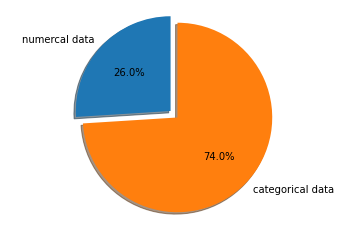

In [ ]:
# plot the data type percentage
labels = "numercal data", "categorical data"
sizes = [13, 37]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As we can see 26% data are numerical data and the rest are categorical.

In [ ]:
# Since we are prediction the level of insulin usage, let's first understand the insulin feature
insulin = data["insulin"]

In [ ]:
insulin.describe()

count     101766
unique         4
top           No
freq       47383
Name: insulin, dtype: object

In [ ]:
unique_insulin_data = set([i for i in insulin])

# We have 4 unique category in this insulin data
Down, No, Steady, Up = 0, 0, 0, 0
for i in insulin:
    if i == "Down":
        Down+=1
    if i == "No":
        No +=1
    if i == "Steady":
        Steady += 1
    if i == "Up":
        Up += 1

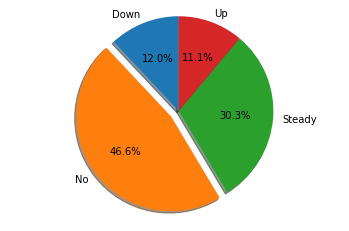

In [ ]:
# plot the data type percentage
labels = "Down", "No", "Steady", "Up"
sizes = [Down, No, Steady, Up]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
# Need to convert all categorical features to numerical
def feature_transformation(df):
    """
        Return transformed dataframe and feature map to convert feature back from numerical to categorical
    """
    feature_map = {}
    counter = 0
    for name in df.columns:
        unique_cate = list(i for i in set([i for i in df[name]]))
        cate_dict = {}
        for i in range(len(unique_cate)):
            cate_dict[unique_cate[i]] = i
        feature_map[name] = cate_dict
        
        iter_counter = 0
        for i in df[name]:
            df[name][iter_counter] = cate_dict[i]
            iter_counter += 1
        counter += 1
        print(counter)
    return df, feature_map

In [ ]:
# Do not run this cell. This takes very long time.
cate_df = data[data_type["categorical data"][0]]
cate_df, feature_map = feature_transformation(cate_df)

<ipython-input-59-5fa2117ac255>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cate_df, feature_map = feature_transformation(cate_df)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [ ]:
# save cate_df as csv
cate_df.to_csv("cate_df.csv", index = 0)

# save feature map as json file
with open('feature_map.json', 'w') as fp:
    json.dump(feature_map, fp)

### Part 1.1: Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [ ]:
# load categorical dataframe
cate_df = pd.read_csv("/content/drive/MyDrive/dataset_diabetes/cate_df.csv")
numerical_df = data[data_type["numerical data"][0]]

In [ ]:
all_df = pd.concat([cate_df, numerical_df], axis=1)

In [ ]:
# Let's first try to do the feature selection
all_features = all_df.copy()
insulin = all_features["insulin"]
all_features = all_features.drop(columns = "insulin")

In [ ]:
def ridge_selector(X, y, n):
    ridge = Ridge().fit(X,y)
    embeded_lr_selector = SelectFromModel(ridge, max_features=n).fit(X, y)
    embeded_lr_selector_support = embeded_lr_selector.get_support()
    return embeded_lr_selector_support

def lasso_selector(X, y, n):
    lasso = Lasso(alpha=0.5, max_iter=10000, tol = 0.032).fit(X, y)
    embeded_lr_selector = SelectFromModel(lasso, max_features=n).fit(X, y)
    embeded_lr_selector_support = embeded_lr_selector.get_support()
    return embeded_lr_selector_support

def rf_selector(X, y, n):
    rf = DecisionTreeRegressor(random_state=1)
    embeded_rf_selector = SelectFromModel(rf, max_features=n).fit(X, y)
    embeded_rf_selector_support = embeded_rf_selector.get_support()
    return embeded_rf_selector_support

def RFE_selector(X, y, n):
    rfe_selector = RFE(estimator=DecisionTreeRegressor(random_state=1), n_features_to_select=n, step=5, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    return rfe_support

def svr_selector(X, y, n):
    selector = SelectFromModel(estimator=LinearSVR(), max_features=n).fit(X, y)
    svr_selector_support = selector.get_support()
    return svr_selector_support

def mutual_information_selector(X, y, n):
    '''
      This is a method which returns the new dataframe of the n top features to select on mutual_info_regression score
    '''
    mir_selector = SelectKBest(mutual_info_regression, k=n)
    mir_selector.fit(X, y)
    mir_support = mir_selector.get_support()
    return mir_support

In [ ]:
# Holistic Feature Selection
def feature_select_tb(x, y, n, ridge = False, lasso = False):
    feature_col = [i for i in x.columns]
    if ridge:
        ridge_idx = []
        ridge_counter = 0
        for i in ridge_selector(x, y, n):
            if i == True:
                ridge_idx.append(ridge_counter)
            ridge_counter += 1
        ridge_feature = [feature_col[i] for i in ridge_idx]

    if lasso:
        lasso_idx = []
        lasso_counter = 0
        for i in lasso_selector(x, y, n):
            if i == True:
                lasso_idx.append(lasso_counter)
            lasso_counter += 1
        lasso_feature = [feature_col[i] for i in lasso_idx]

    RFE_idx = []
    RFE_counter = 0
    for i in RFE_selector(x, y, n):
        if i == True:
            RFE_idx.append(RFE_counter)
        RFE_counter += 1
    RFE_feature = [feature_col[i] for i in RFE_idx]

    svr_idx = []
    svr_counter = 0
    for i in svr_selector(x, y, n):
        if i == True:
            svr_idx.append(svr_counter)
        svr_counter += 1
    svr_feature = [feature_col[i] for i in svr_idx]

    mi_idx = []
    mi_counter = 0
    for i in mutual_information_selector(x, y, n):
        if i == True:
            mi_idx.append(mi_counter)
        mi_counter += 1
    mi_feature = [feature_col[i] for i in mi_idx]

    if ridge:
        print("ridge:", ridge_feature)
        print("rfe:", RFE_feature)
        print("svr:", svr_feature)
        print("mi:", mi_feature)

    if lasso:
        print("lasso:", lasso_feature)
        print("rfe:", RFE_feature)
        print("svr:", svr_feature)
        print("mi:", mi_feature)

In [ ]:
# Selection 1: 50% features. In our case, we will use ridge (L1) to select the most important feature.
feature_select_tb(all_features, insulin, 20, ridge = True, lasso = False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.81827e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.81827e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


ridge: ['metformin', 'repaglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'acarbose', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']
rfe: ['payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'glyburide-metformin', 'change', 'diabetesMed', 'encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_medications']
svr: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide']
mi: ['weight', 'payer_code', 'medical_specialty', 'A1Cresult', 'metformin', 'glyburide', 'tolbut

In [ ]:
# Save all selected feature for cross-comparisons
ridge = ['metformin', 'repaglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'acarbose', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']
rfe = ['payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'glyburide-metformin', 'change', 'diabetesMed', 'encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_medications']
svr = ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide']
mi = ['weight', 'payer_code', 'medical_specialty', 'diag_2', 'A1Cresult', 'glipizide', 'glyburide', 'glyburide-metformin', 'change', 'diabetesMed', 'encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_emergency', 'number_inpatient', 'number_diagnoses']

In [ ]:
# Cross feature comparisons for the top features based on repetition
feature_col = all_features.columns
counter_dict = {}
for i in feature_col:
    counter_dict[i] = [i, 0]

for i in feature_col:
    if i in ridge:
        counter_dict[i][1] += 1
    if i in rfe:
        counter_dict[i][1] += 1
    if i in svr:
        counter_dict[i][1] += 1
    if i in mi:
        counter_dict[i][1] += 1
    else:
        counter_dict[i][1] += 0

In [ ]:
sorted_selected_feature = sorted([counter_dict[i] for i in counter_dict], key = lambda x: x[1], reverse = True)

In [ ]:
sorted_selected_feature

[['glipizide', 4],
 ['glyburide', 4],
 ['payer_code', 3],
 ['medical_specialty', 3],
 ['diag_2', 3],
 ['metformin', 3],
 ['repaglinide', 3],
 ['glimepiride', 3],
 ['glyburide-metformin', 3],
 ['change', 3],
 ['diabetesMed', 3],
 ['weight', 2],
 ['diag_1', 2],
 ['diag_3', 2],
 ['A1Cresult', 2],
 ['chlorpropamide', 2],
 ['acetohexamide', 2],
 ['tolbutamide', 2],
 ['encounter_id', 2],
 ['patient_nbr', 2],
 ['time_in_hospital', 2],
 ['num_lab_procedures', 2],
 ['num_medications', 2],
 ['race', 1],
 ['gender', 1],
 ['age', 1],
 ['max_glu_serum', 1],
 ['nateglinide', 1],
 ['pioglitazone', 1],
 ['rosiglitazone', 1],
 ['acarbose', 1],
 ['troglitazone', 1],
 ['tolazamide', 1],
 ['glipizide-metformin', 1],
 ['glimepiride-pioglitazone', 1],
 ['metformin-rosiglitazone', 1],
 ['metformin-pioglitazone', 1],
 ['admission_type_id', 1],
 ['discharge_disposition_id', 1],
 ['number_emergency', 1],
 ['number_inpatient', 1],
 ['number_diagnoses', 1],
 ['miglitol', 0],
 ['examide', 0],
 ['citoglipton', 0],


In [ ]:
# Select the first 11 features
final_selected_features = [i[0] for i in sorted_selected_feature][:11]
final_selected_features

['glipizide',
 'glyburide',
 'payer_code',
 'medical_specialty',
 'diag_2',
 'metformin',
 'repaglinide',
 'glimepiride',
 'glyburide-metformin',
 'change',
 'diabetesMed']

In [ ]:
# show the selected feature's stats
all_features[final_selected_features].describe()

,glipizide,glyburide,payer_code,medical_specialty,diag_2,metformin,repaglinide,glimepiride,glyburide-metformin,change,diabetesMed
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.353340,0.292455,14.151318,25.944962,354.699123,0.562614,0.042765,0.144695,0.020596,0.461952,0.770031
std,0.953437,0.874529,4.127565,20.420120,191.927805,1.157174,0.351313,0.634754,0.247164,0.498553,0.420815
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,15.000000,11.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,15.000000,11.000000,367.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,17.000000,48.000000,453.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,3.000000,17.000000,72.000000,748.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000


## Part 2: Train models

### Part 2.1: Logistic Regression

In [ ]:
X = all_features[final_selected_features]
y = insulin

In [ ]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score                                             
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Split data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
# Now we have selected features and our target. We can start working on our model.
# Let's first try logisitic regression

# evaluate multinomial logistic regression model

from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# train the model
logistic_model.fit(X_train, y_train)
prediction = logistic_model.predict(X_test)

# evaluation: All score are calculated based on weighted score except model testing accuracy
print("Model: Logistic Regression")
print(classification_report(y_test, prediction))


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9549
           1       0.34      0.10      0.15      2249
           2       0.37      0.28      0.32      2410
           3       0.46      0.59      0.52      6146

    accuracy                           0.60     20354
   macro avg       0.48      0.44      0.44     20354
weighted avg       0.58      0.60      0.58     20354



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


This is the highest score we can get using logisitc regression by selecting the first 11 features.

### Part 2.2: Naive Bayes

In [ ]:
# Now, after using the logisitc regression, let's try multinomial naive bayes on this problem.
from sklearn.naive_bayes import MultinomialNB

# define naive bayes model
nb_model = MultinomialNB()

# train the model
nb_model.fit(X_train, y_train)
prediction = nb_model.predict(X_test)

# evaluate the model
# evaluation: All score are calculated based on weighted score except model testing accuracy
print("Model: Multinomial Naive Bayes")
print(classification_report(y_test, prediction))

Model: Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      9549
           1       0.33      0.38      0.35      2249
           2       0.35      0.02      0.04      2410
           3       0.34      0.44      0.38      6146

    accuracy                           0.49     20354
   macro avg       0.42      0.38      0.36     20354
weighted avg       0.49      0.49      0.47     20354



### Part 2.3: Passive Aggressive Classifier

In [ ]:
# Let's try Passove Aggressive Classifier.
from sklearn.linear_model import PassiveAggressiveClassifier
pac_model = PassiveAggressiveClassifier(max_iter=5000, random_state=2, tol=1e-2, early_stopping= True)

# train PAC
pac_model.fit(X_train, y_train)
prediction = pac_model.predict(X_test)

# evaluate the model
# evaluation: All score are calculated based on weighted score except model testing accuracy
print("Model: PAC")
print(classification_report(y_test, prediction))

Model: PAC
              precision    recall  f1-score   support

           0       0.94      0.59      0.72      9549
           1       0.00      0.00      0.00      2249
           2       0.18      0.98      0.30      2410
           3       0.81      0.16      0.27      6146

    accuracy                           0.44     20354
   macro avg       0.48      0.43      0.32     20354
weighted avg       0.71      0.44      0.46     20354



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 2.4: XgBoost

In [ ]:
# Now let's try the Xgboost for this problem.
from xgboost import XGBClassifier
model_xgb = XGBClassifie
model_xgb.fit(X_train, y_train)
prediction = model_xgb.predict(X_test)

# evaluate the model
# evaluation: All score are calculated based on weighted score except model testing accuracy
print("Model: XgBoost")
print(classification_report(y_test, prediction))

Model: XgBoost
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      9549
           1       0.41      0.04      0.08      2249
           2       0.45      0.68      0.54      2410
           3       0.67      0.84      0.75      6146

    accuracy                           0.73     20354
   macro avg       0.61      0.60      0.56     20354
weighted avg       0.73      0.73      0.71     20354



### Part 2.5: Neural Network for Multiclass Classification

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler  

In [ ]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=21)

In [ ]:
"""
  We scale the train and validation data with minimax scaler. We do this because we want to scale the validation and
  test set with the same parameters as that of the train set to avoid data leakage. fit_transform calculates 
  scaling values and applies them while .transform only applies the calculated values.
"""
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
  # check the insulin class number distribution.
    count_dict = {
        "class_0": 0,
        "class_1": 0,
        "class_2": 0,
        "class_3": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1
        elif i == 2: 
            count_dict['class_2'] += 1
        elif i == 3: 
            count_dict['class_3'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

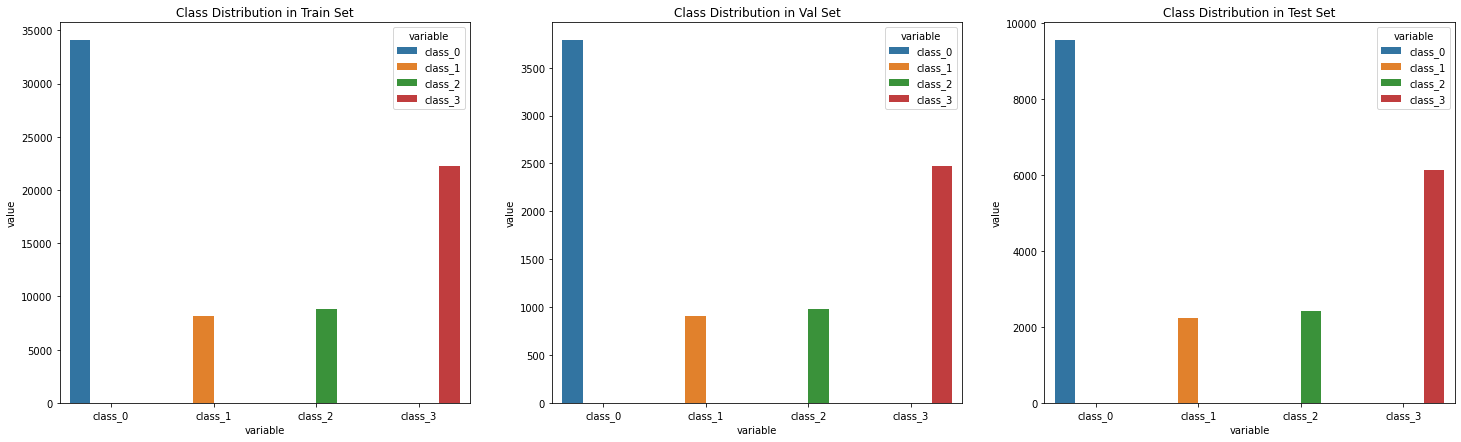

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

We can clearly see that the class in the target set are highly imbalanced. This is also proved in the first part.

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [ ]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([2.9369e-05, 1.2255e-04, 1.1329e-04, 4.4978e-05])


In [ ]:
# We get the class weight for balanced sampling during the data loading process
class_weights_all = class_weights[target_list]

In [ ]:
# define the weighted_sampler for Dataloader
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
# Start FNN training

# Configure hyperparameters
EPOCHS = 300
BATCH_SIZE = 32
LEARNING_RATE = 0.008
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4

# load data using Dataloader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

class MulticlassClassification(nn.Module):
    '''
      Define a 4 layer neural network with ReLu activation.
    '''
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_4 = nn.Linear(16,8)
        self.layer_out = nn.Linear(8, num_class) 
        
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.batchnorm3 = nn.BatchNorm1d(16)
        self.batchnorm4 = nn.BatchNorm1d(8)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.tanh(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        x = self.softmax(x)
        
        return x


In [ ]:
# check whether GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# define model and check all model configurations
# in this problem, we use adam as our optimizer.
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=4, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
  (softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|   layer_1.weight  |    704     |
|    layer_1.bias   |     64     |
|   layer_2.weight  |    2048    |
|    layer_2.bias   |     32     |
|   layer_3.weight  |    512     |
|    layer_3.bias   |     16     |
|   layer_4.weight  |    128     |
|    layer_4.bias   |     8      |
|  layer_out.weight |     32     |
|   layer_out.bias  |     4      |
| batchnorm1.weight |     64     |
|  batchnorm1.bias  |     64     |
| batchnorm2.weight |     32     |
|  batchnorm2.bias  |     32     |
| batchnorm3.weight |     16     |
|  batchnorm3.bias  |     16     |
| batchnorm4.weight |     8      |
|  batchnorm4.bias  |     8      |
+-------------------+------------+
Total Trainable Params: 3788


3788

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
# Start training the Neural Network.
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 001: | Train Loss: 1.15911 | Val Loss: 1.08163 | Train Acc: 56.103| Val Acc: 63.105
Epoch 002: | Train Loss: 1.15245 | Val Loss: 1.08186 | Train Acc: 56.879| Val Acc: 62.245
Epoch 003: | Train Loss: 1.15077 | Val Loss: 1.08217 | Train Acc: 57.351| Val Acc: 63.228
Epoch 004: | Train Loss: 1.15030 | Val Loss: 1.08087 | Train Acc: 57.641| Val Acc: 63.203
Epoch 005: | Train Loss: 1.14988 | Val Loss: 1.08105 | Train Acc: 57.693| Val Acc: 62.921
Epoch 006: | Train Loss: 1.14998 | Val Loss: 1.08075 | Train Acc: 57.708| Val Acc: 63.129
Epoch 007: | Train Loss: 1.14948 | Val Loss: 1.08220 | Train Acc: 57.800| Val Acc: 63.007
Epoch 008: | Train Loss: 1.14965 | Val Loss: 1.08126 | Train Acc: 57.698| Val Acc: 63.105
Epoch 009: | Train Loss: 1.14865 | Val Loss: 1.08652 | Train Acc: 58.124| Val Acc: 62.859
Epoch 010: | Train Loss: 1.14961 | Val Loss: 1.08147 | Train Acc: 57.598| Val Acc: 62.994
Epoch 011: | Train Loss: 1.14795 | Val Loss: 1.08119 | Train Acc: 58.093| Val Acc: 63.105
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

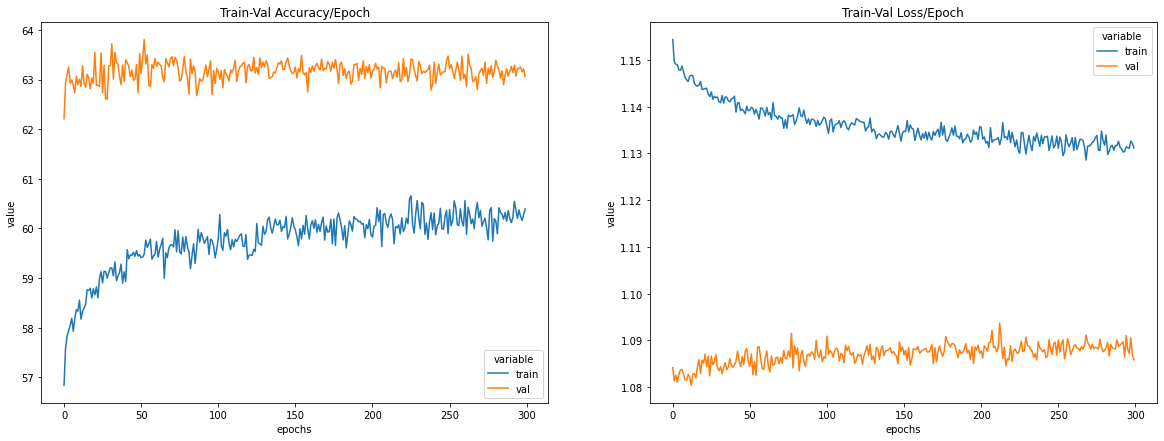

In [ ]:
# Visualize loss and accuracy
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      9549
           1       0.27      0.51      0.35      2249
           2       0.26      0.55      0.36      2410
           3       0.86      0.53      0.66      6146

    accuracy                           0.64     20354
   macro avg       0.60      0.59      0.56     20354
weighted avg       0.79      0.64      0.68     20354



## Part 3: Performance Conclusion

For Testing Accuracy: 
**XgBoost > Neural Network > Logistic Regression > Multinomial Naive Bayes > Passive Aggressive Classifier.**